In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

##Methods Overview:
  1) Time Series Regression 
      - Additive decomposition: estimate trend, seasonal, cyclical, and irregular factors
      
  

#Time Series Regression

In [2]:
#first daata..
df = pd.read_csv('data/birth.txt', delim_whitespace=True)

In [3]:
#create some dates that go with the birth. Its a Time! 
df['dates'] = pd.date_range('1980-01','2011-01', freq='M') #AS for anual, 
df.head()

,num_births,dates
0,295,1980-01-31
1,286,1980-02-29
2,300,1980-03-31
3,278,1980-04-30
4,272,1980-05-31


In [4]:
#example 2. The first six days in january, 2013:
dates = pd.date_range('20130101', periods = 6)
print dates

<class 'pandas.tseries.index.DatetimeIndex'>
[2013-01-01, ..., 2013-01-06]
Length: 6, Freq: D, Timezone: None


###make the dates an index!

In [5]:
d_dateindex = df.set_index('dates')
d_dateindex.head()

,num_births
dates,
1980-01-31,295
1980-02-29,286
1980-03-31,300
1980-04-30,278
1980-05-31,272


##Get the month or Day as a New column!

In [6]:
df['months'] = pd.DatetimeIndex(df['dates']).month
df['years'] = pd.DatetimeIndex(df['dates']).year
df.head()

,num_births,dates,months,years
0,295,1980-01-31,1,1980
1,286,1980-02-29,2,1980
2,300,1980-03-31,3,1980
3,278,1980-04-30,4,1980
4,272,1980-05-31,5,1980


###Resample Quarterly:

follows the season, with Nov starting as fall

In [7]:
#need datetime as index

d_dateindex.resample('Q-Nov').head()

,num_births
dates,
1980-02-29,290.500000
1980-05-31,283.333333
1980-08-31,299.000000
1980-11-30,304.000000
1981-02-28,287.666667


##Use Groupby to Get Cool Aggregates by Month/year! 

if you have the dates as and index, you can use pd.TimeGrouper

In [8]:
year_averages = d_dateindex.groupby(pd.TimeGrouper(freq='AS')).agg(np.mean)
year_averages.head()

,num_births
dates,
1980-01-01,294.666667
1981-01-01,296.166667
1982-01-01,296.166667
1983-01-01,312.583333
1984-01-01,320.416667


or, make the year a seperate column, and just use groupby....

In [11]:
df.groupby(['years'])['num_births'].mean()

years
1980    294.666667
1981    296.166667
1982    296.166667
1983    312.583333
1984    320.416667
1985    325.000000
1986    335.000000
1987    337.166667
1988    347.000000
1989    354.416667
1990    350.333333
1991    353.750000
1992    353.916667
1993    356.750000
1994    347.083333
1995    341.750000
1996    337.750000
1997    313.833333
1998    302.500000
1999    293.916667
2000    290.416667
2001    297.750000
2002    309.916667
2003    296.666667
2004    271.333333
2005    261.500000
2006    263.833333
2007    262.416667
2008    265.583333
2009    275.000000
2010    278.666667
Name: num_births, dtype: float64

In [12]:
df.groupby(['months'])['num_births'].mean()

months
1     306.225806
2     288.451613
3     308.935484
4     290.580645
5     300.483871
6     304.129032
7     327.870968
8     334.161290
9     330.032258
10    322.838710
11    305.645161
12    313.516129
Name: num_births, dtype: float64

###Cool Example to Plot cyclical Data

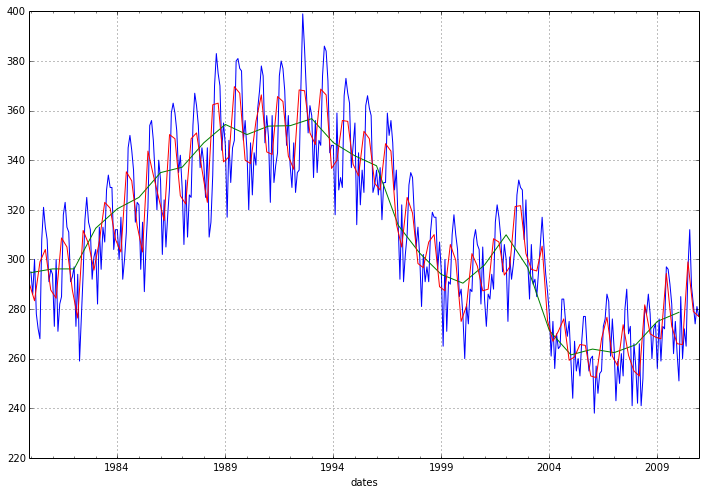

In [15]:
#turn it into a timeseries by taking it out of a dataframe
ts = pd.Series(d_dateindex['num_births'])

ts.plot(figsize=(12,8)) #this is the daily data (blue)
ts.resample('Q-NOV').plot() #seasons (red)
ts.resample('A').plot() #yearly (green)

plt.show()

##How To Model TimeSeries:

In [19]:
#create a time variable for modeling:

d_dateindex['time'] = range(1,d_dateindex.shape[0]+1)
d_dateindex.head()


,num_births,time
dates,,
1980-01-31,295,1
1980-02-29,286,2
1980-03-31,300,3
1980-04-30,278,4
1980-05-31,272,5


In [20]:
#now create multiple polynomial variables for modeling

d_dateindex['time^2'] = d_dateindex['time']**2
d_dateindex['time^3'] = d_dateindex['time']**3 
d_dateindex['time^4'] = d_dateindex['time']**4 
d_dateindex['time^5'] = d_dateindex['time']**5 
d_dateindex.head()

,num_births,time,time^2,time^3,time^4,time^5
dates,,,,,,
1980-01-31,295,1,1,1,1,1
1980-02-29,286,2,4,8,16,32
1980-03-31,300,3,9,27,81,243
1980-04-30,278,4,16,64,256,1024
1980-05-31,272,5,25,125,625,3125


##CREATE A MODEL

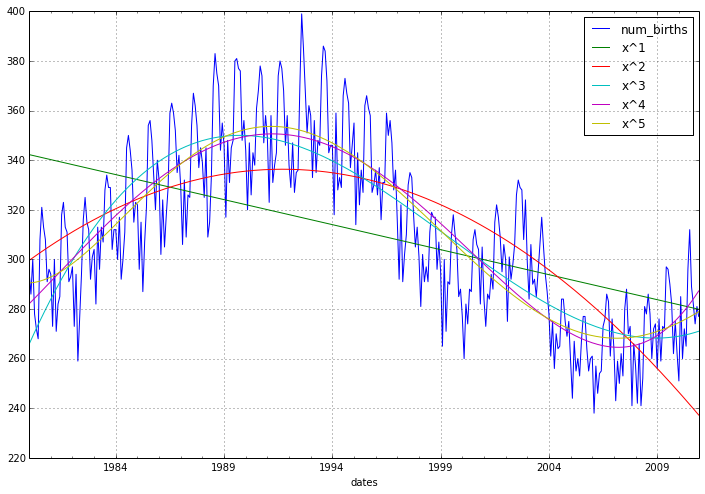

In [26]:
y = d_dateindex.num_births

def make_model(y, x_values):
    ts.plot(figsize=(12,8))
    for i,x in enumerate(x_values):
        xs = x_values[:i+1]
        x_value = d_dateindex[xs]
        model = sm.OLS(y, sm.add_constant(x_value)).fit()
        
        labname = 'x^' + str(i+1) 
        pd.Series(model.fittedvalues, index = d_dateindex.index).plot(label=labname)

make_model(y, ['time', 'time^2', 'time^3', 'time^4', 'time^5'])
plt.legend()
plt.show()

In [28]:
def evaluate_model(y,Xs):
    for i, x in enumerate(Xs):        
        xs = d_dateindex[Xs[:i+1]]
        print
        model = sm.OLS(y, sm.add_constant(xs)).fit()
        print model.summary()
        
evaluate_model(y, ['time', 'time^2', 'time^3', 'time^4', 'time^5'])
'''
X | AIC | BIC
-------------
1  3593  3601
2  3400  3412
3  3262  3278
4  3231  3251
5  3224  3243
'''


                            OLS Regression Results                            
Dep. Variable:             num_births   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     133.0
Date:                Tue, 14 Jul 2015   Prob (F-statistic):           1.72e-26
Time:                        11:02:15   Log-Likelihood:                -1794.5
No. Observations:                 372   AIC:                             3593.
Df Residuals:                     370   BIC:                             3601.
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        342.4232      3.137    109.148      0.000       336.254   348.592
time          -0.1681      0.015    -11.531      0.

'\nX | AIC | BIC\n-------------\n1  3593  3601\n2  3400  3412\n3  3262  3278\n4  3231  3251\n5  3224  3243\n'

###oops.. break it down! The loops make it confusing!

So, an exaple to add two constants:
    

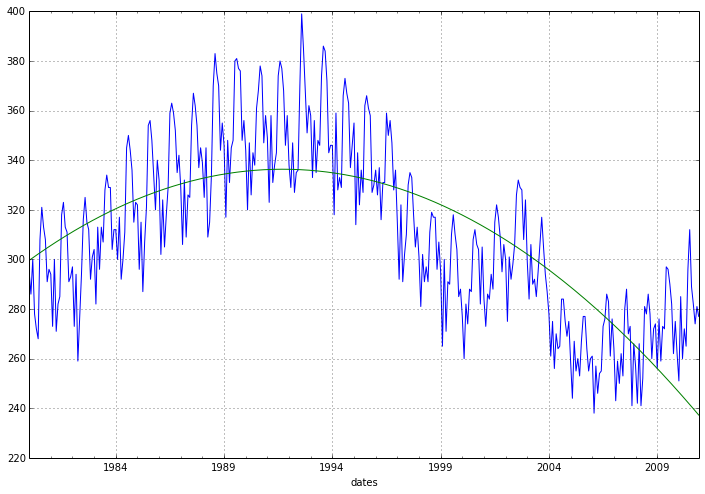

In [50]:
y = d_dateindex['num_births']
X = d_dateindex[['time', 'time^2']]
model = sm.OLS(y, sm.add_constant(X)).fit()
ts.plot(figsize=(12,8))
pd.Series(model.fittedvalues, index=d_dateindex.index).plot()

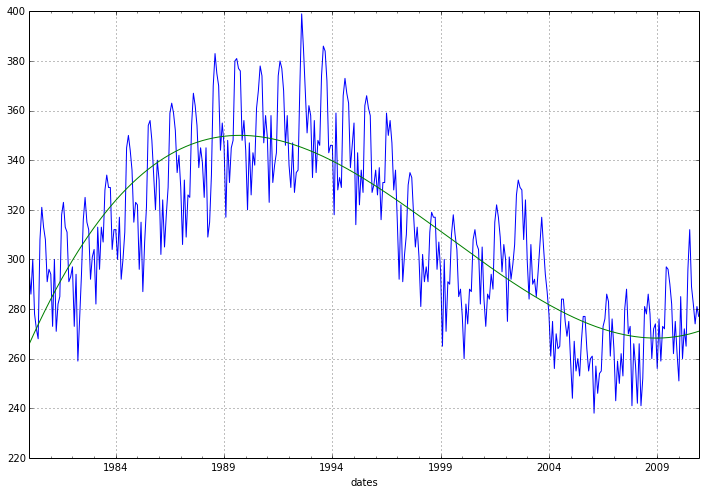

In [49]:
X = d_dateindex[['time', 'time^2', 'time^3']]
model = sm.OLS(y, sm.add_constant(X)).fit()
ts.plot(figsize=(12,8))
pd.Series(model.fittedvalues, index=d_dateindex.index).plot()

now. We can account for more variables than just adding terms to X (time)
We might want to incorporate the fact that all the months change.
- to do this, make months a dummy variable, so that you include waht month it is in the model. This is added to the other x's (time, time^2, ect)

In [60]:
d_dateindex['month'] = pd.DatetimeIndex(d_dateindex.index).month
X = pd.get_dummies(d_dateindex[['time', 'time^2', 'time^3', 'time^4','month']], columns=['month']).drop(['month_1'], axis = 1)

In [61]:
d_dateindex.head()

,num_births,time,time^2,time^3,time^4,time^5,month
dates,,,,,,,
1980-01-31,295,1,1,1,1,1,1
1980-02-29,286,2,4,8,16,32,2
1980-03-31,300,3,9,27,81,243,3
1980-04-30,278,4,16,64,256,1024,4
1980-05-31,272,5,25,125,625,3125,5


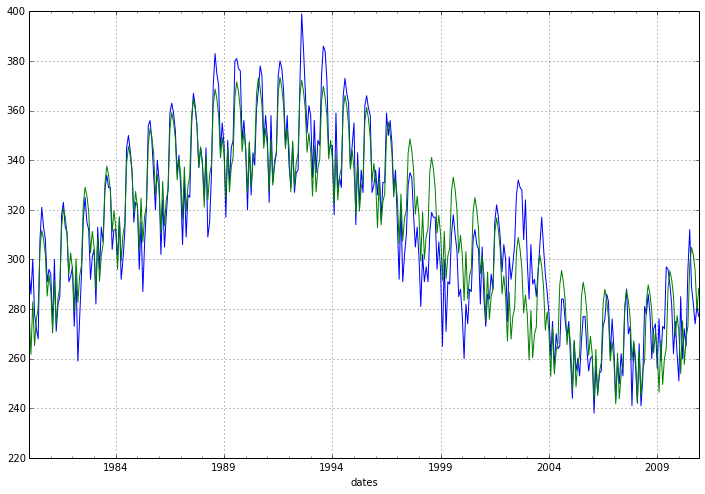

In [62]:
model = sm.OLS(y, sm.add_constant(X)).fit()
ts.plot(figsize=(12,8))
pd.Series(model.fittedvalues, index=d_dateindex.index).plot()

##Plot Residuals

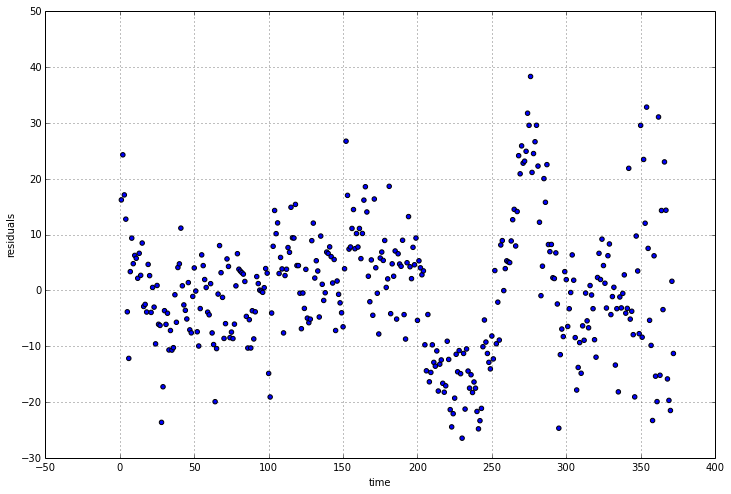

In [64]:
d_dateindex['residuals'] = model.resid
d_dateindex.plot(x = 'time', y = 'residuals', kind = 'scatter', figsize=(12,8))